# Using Latte with TensorFlow/Keras

This example notebook demonstrates the use of [Latte](https://github.com/karnwatcharasupat/latte) with [TensorFlow](https://tensorflow.org/). 

The code in this notebook is adapted from the [AR-VAE](https://github.com/ashispati/ar-vae) implementation:
> A. Pati and A. Lerch, Attribute-based regularization of latent spaces for variational auto-encoders. Neural Computing & Applications, 33, 4429–4444 (2021). https://doi.org/10.1007/s00521-020-05270-2


For this notebook, we will be using the [Morpho-MNIST](https://github.com/dccastro/Morpho-MNIST) dataset which is a disentanglement dataset built on the usual MNIST dataset.

**Before you begin, please turn on GPU accelerator at `Runtime > Change runtime type > Hardware accelerator > GPU`.**

In [1]:
HOME = '/content'

## Installing Latte and Dependencies

In [ ]:
# This command automatically install PyTorch and TorchMetrics.
# For users with existing tensorflow>=2.0 installation, 
#   use `pip install latte-metrics` with no extras
!pip install latte-metrics --upgrade

!pip install tensorflow-probability

## Preparing data

### Downloading dataset

In [ ]:
%%bash

export DSET_PATH="/content/dataset" 
mkdir -p $DSET_PATH
gdown --id "1fFGJW0IHoBmLuD6CEKCB8jz3Y5LJ5Duk" -O $DSET_PATH/morphomnist.zip
unzip -o "$DSET_PATH/morphomnist.zip" -d $DSET_PATH

### Cloning Morpho-MNIST measurement code

In [ ]:
!git clone https://github.com/dccastro/Morpho-MNIST

In [ ]:
import os, sys
sys.path.append(os.path.join(HOME, 'Morpho-MNIST'))

### Creating dataloader

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.data import Dataset
from morphomnist import io, morpho

class MorphoMnistDataset():

    def __init__(self, root_dir=os.path.join(HOME, 'dataset/global')):
        super().__init__()
        self.root_dir = root_dir
        self.data_path_str = "-images-idx3-ubyte.gz"
        self.label_path_str = "-labels-idx1-ubyte.gz"
        self.morpho_path_str = "-morpho.csv"

        self.train_dataset = self._create_dataset(dataset_type="train")
        self.val_dataset = self._create_dataset(dataset_type="t10k")

    def train_data(self, limit=None):
        return self.train_dataset
    
    def val_data(self, limit=None):
        return self.val_dataset

    def _create_dataset(self, dataset_type):
        data_path = os.path.join(
            self.root_dir,
            dataset_type + self.data_path_str
        )
        morpho_path = os.path.join(
            self.root_dir,
            dataset_type + self.morpho_path_str
        )
        images = io.load_idx(data_path)
        images = np.expand_dims(images, axis=-1).astype('float32') / 255.0
        morpho_labels = pd.read_csv(morpho_path).values.astype('float32')[:, 3:]
        
        
        images = Dataset.from_tensor_slices(images)
        morpho_labels = Dataset.from_tensor_slices(morpho_labels)
        
        dataset = Dataset.zip((images, morpho_labels))
        return dataset

## Creating a simple AR-VAE

### Defining the Loss Function

In [5]:
from tensorflow_probability import distributions

def ar_signed_loss(z, a, factor=10.0):

    n_attr = a.shape[-1]

    # compute latent distance matrix
    lc_dist_mat = z[:, None, :n_attr] - z[None, :, :n_attr]

    # compute attribute distance matrix
    attribute_dist_mat = a[:, None, ...] - a[None, :, :]

    # compute regularization loss
    lc_tanh = tf.tanh(lc_dist_mat * factor)
    attribute_sign = tf.sign(attribute_dist_mat)
    batch_size = z.shape[0]
    ar_loss = tf.reduce_sum(tf.abs(lc_tanh - attribute_sign))/(batch_size ** 2 - batch_size)

    return ar_loss

def compute_loss(x, xhat, zd, z0, z, a, beta=1.0, gamma=1.0):

    recon_loss = tf.reduce_sum(tf.math.squared_difference(x, tf.sigmoid(xhat)))/z.shape[0]

    kld_loss = tf.reduce_mean(distributions.kl_divergence(zd, z0))

    ar_loss = ar_signed_loss(z, a)

    return {
        'loss': recon_loss + beta * kld_loss + gamma * ar_loss,
        'recon_loss': recon_loss,
        'kld_loss': kld_loss,
        'ar_loss': ar_loss
    }

### Defining base VAE class

In [43]:
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class ImageVAE(tfk.Model):
    def __init__(self):
        super().__init__()
        self.input_size = 784
        self.z_dim = 16
        self.inter_dim = 19
        self.enc_conv = tfk.Sequential([
            tfkl.Conv2D(64, 4, 1, activation='selu'),
            tfkl.Dropout(0.5),
            tfkl.Conv2D(64, 4, 1, activation='selu'),
            tfkl.Dropout(0.5),
            tfkl.Conv2D(8, 4, 1, activation='selu'),
            tfkl.Dropout(0.5),
        ])
        self.enc_lin = tfkl.Dense(256, activation='selu')
        self.enc_mean = tfkl.Dense(self.z_dim)
        self.enc_log_std = tfkl.Dense(self.z_dim)
        self.dec_lin = tfk.Sequential([
            tfkl.Dense(256, activation='selu'),
            tfkl.Dense(2888, activation='selu')
        ])
        self.dec_conv = tfk.Sequential([
            tfkl.Conv2DTranspose(64, 4, 1, activation='selu'),
            tfkl.Dropout(0.5),
            tfkl.Conv2DTranspose(64, 4, 1, activation='selu'),
            tfkl.Dropout(0.5),
            tfkl.Conv2DTranspose(1, 4, 1, activation='selu'),
        ])

    @tf.function
    def encode(self, x):
        hidden = self.enc_conv(x)
        hidden = tf.reshape(hidden, (hidden.shape[0], -1))
        hidden = self.enc_lin(hidden)
        z_mean = self.enc_mean(hidden)
        z_log_std = self.enc_log_std(hidden)
        z_distribution = distributions.Normal(loc=z_mean, scale=tf.exp(z_log_std) + 1e-16)
        return z_distribution

    @tf.function
    def decode(self, z):
        hidden = self.dec_lin(z)
        hidden = tf.reshape(hidden, (z.shape[0], self.inter_dim, self.inter_dim, -1))
        hidden = self.dec_conv(hidden)
        return hidden

    @tf.function
    def reparametrize(self, z_dist):
        # sample from distribution
        z_tilde = z_dist.sample()

        # compute prior
        prior_dist = distributions.Normal(
            loc=tf.zeros_like(z_dist.loc),
            scale=tf.ones_like(z_dist.scale)
        )
        return z_tilde, prior_dist
    
    @tf.function
    def interpolate(self, x, dz):
        
        # compute distribution using encoder
        z_dist = self.encode(x)

        # reparametrize
        z_tilde, prior_dist = self.reparametrize(z_dist)

        # compute output of decoding layer
        if len(dz.shape) > 1:
            output = []
            for i in range(dz.shape[-1]):
                output.append(tf.reshape(self.decode(z_tilde + dz[None, :, i]), x.shape))
            output = tf.stack(output, axis=-1)
        else:
            output = tf.reshape(self.decode(z_tilde + dz[None, :]), x.shape)

        return output

### Add custom training to the model

See Latte documentation [here](https://latte.readthedocs.io/).

In [67]:
from latte.metrics.keras.bundles import DependencyAwareMutualInformationBundle

class ImageVAEwithLatte(ImageVAE):
    def __init__(self):
        super().__init__()
        
        self.dami = DependencyAwareMutualInformationBundle(reg_dim=range(4))
        
    def call(self, x):
        # compute distribution using encoder
        z_dist = self.encode(x)

        # reparametrize
        z_tilde, prior_dist = self.reparametrize(z_dist)

        # compute output of decoding layer
        output = tf.reshape(self.decode(z_tilde), x.shape)

        return output, z_dist, prior_dist, z_tilde
    
    def train_step(self, data):
        x, a = data

        with tf.GradientTape() as tape:
            output, z_dist, prior_dist, z_tilde = self(x, training=True)
            loss = compute_loss(x, output, z_dist, prior_dist, z_tilde, a)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss['loss'], trainable_vars)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update metrics (we will compile Latte metric into the model later)
        self.dami.update_state(z_tilde, a)
        return {**loss, **self.dami.result()}
    
    def test_step(self, data):
        x, a = data
        output, z_dist, prior_dist, z_tilde = self(x, training=True)
        loss = compute_loss(x, output, z_dist, prior_dist, z_tilde, a)
        
        self.dami.update_state(z_tilde, a)
        
        return loss
    
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_state()` yourself at the time of your choosing.
        return [self.dami]
    
class ValidationMetricsCallback(tfk.callbacks.Callback):
    def on_test_end(self, logs=None):
        val_metrics = self.model.dami.result()
        
        print("\nValidation metrics: ")
        for k in val_metrics:
            print(f"{k}: ", val_metrics[k].numpy().mean())

## Training the model

For your convenience, we have prepared pretrained weights for the model. This notebook will only train for one more epoch as an example.

In [ ]:
!wget https://github.com/karnwatcharasupat/latte/raw/issues/17-examples/examples/morphomnist-tf-weights.h5

In [68]:
import latte

latte.seed(42) 
# there is no need for this
# this is just to demonstrate that you can manually set a seed
# Latte uses seed=42 by default anyway

tf.random.set_seed(42)

model = ImageVAEwithLatte()

dataset = MorphoMnistDataset(root_dir='/home/karn/data/global')
train_data = dataset.train_data().take(6000).shuffle(6000).batch(32, drop_remainder=True)
val_data = dataset.val_data().take(1000).batch(32, drop_remainder=True)

model.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
    run_eagerly=True, # to evaluate latte metrics mid-training, eager mode is currently required
)

model.build((32, 28, 28, 1))
model.load_weights('/home/karn/mir/latte/examples/morphomnist-tf-weights.h5')

model.fit(
    train_data,
    validation_data=val_data,
    epochs=1,
    callbacks=[ValidationMetricsCallback()]
)

46/46 [==============================] - ETA: 0s - loss: 18.5871 - recon_loss: 17.8086 - kld_loss: 0.2987 - ar_loss: 0.4798 - MIG: 0.2083 - DMIG: 0.2208 - DLIG: 0.2258 - XMIG: 0.2555
Validation metrics: 
MIG:  0.1742615026185847
DMIG:  0.18238919453023042
DLIG:  0.1864447310580491
XMIG:  0.2138756464061811
46/46 [==============================] - 51s 1s/step - loss: 18.5813 - recon_loss: 17.8020 - kld_loss: 0.2988 - ar_loss: 0.4805 - MIG: 0.2077 - DMIG: 0.2201 - DLIG: 0.2251 - XMIG: 0.2547 - val_loss: 18.7760 - val_recon_loss: 17.9517 - val_kld_loss: 0.3012 - val_ar_loss: 0.5230


## Visualizing the outputs

In [53]:
atttribute_dict = {
    "thickness": 0,
    "slant": 1,
    "width": 2,
    "height": 3
}

In [54]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def interpolate_and_display(model, attribute):
    f = plt.figure(figsize=(16, 16))
    ax = ImageGrid(
        f, 111,  # similar to subplot(111)
        nrows_ncols=(11, 8),  # creates 2x2 grid of axes
        axes_pad=0.1,  # pad between axes in inch.
    )

    inputs = dataset.val_data().map(lambda x, a: x).batch(8).take(1).get_single_element()
    
    dz = np.zeros((16, 10), dtype=np.float32)
    dz[atttribute_dict[attribute], :] = np.linspace(-2.0, 2.0, 10)
    dz = tf.convert_to_tensor(dz)

    gen = model.interpolate(inputs, dz)
    gen = tf.sigmoid(gen)

    for i in range(8):
        ax[i].imshow(inputs[i, :, :, 0], cmap='summer')
        for j in range(10):
            ax[(j+1)*8+i].imshow(gen[i, :, :, 0, j], cmap='gray', vmin=0, vmax=1)
    
    for i in range(8*11):
        ax[i].axis('off')
    
    plt.show()

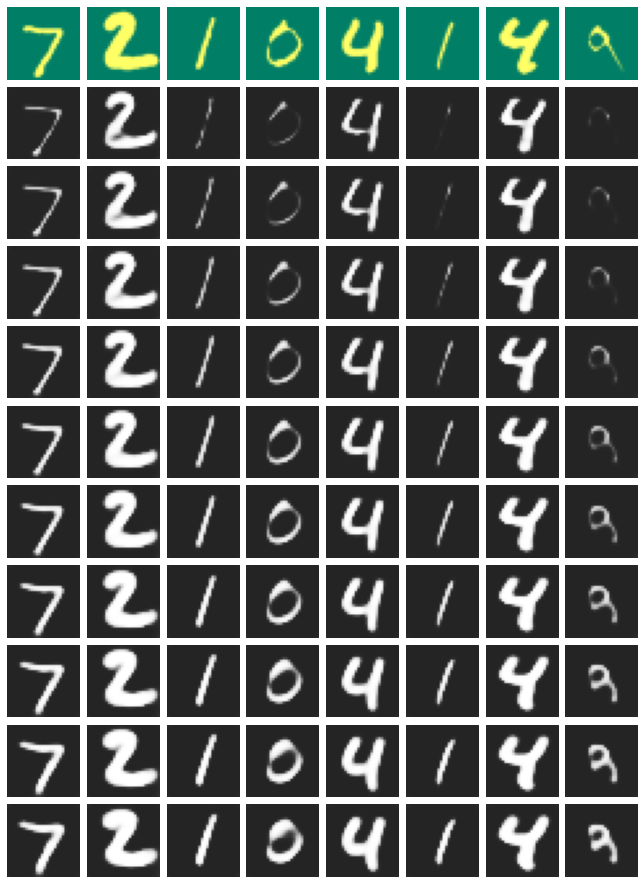

In [55]:
interpolate_and_display(model, 'thickness')

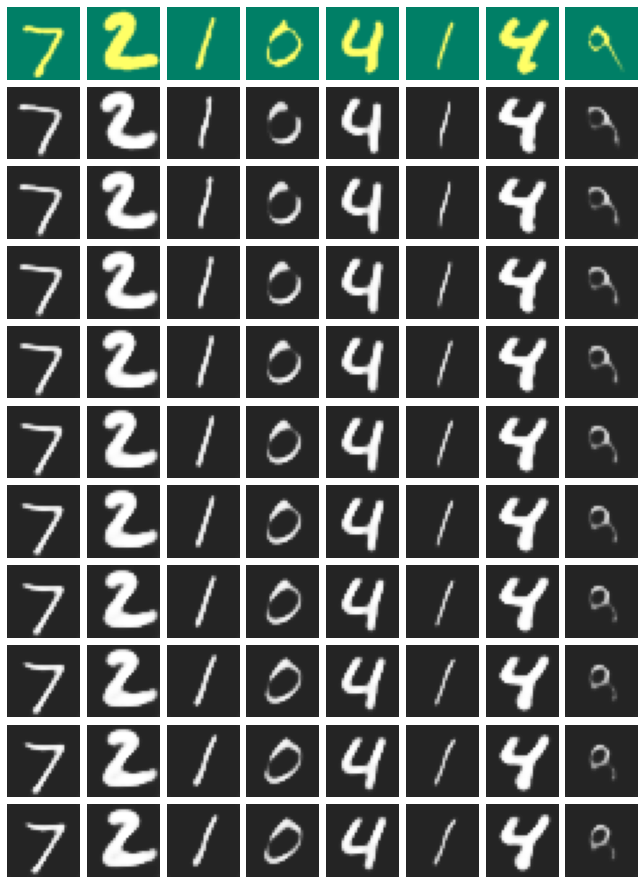

In [56]:
interpolate_and_display(model, 'slant')

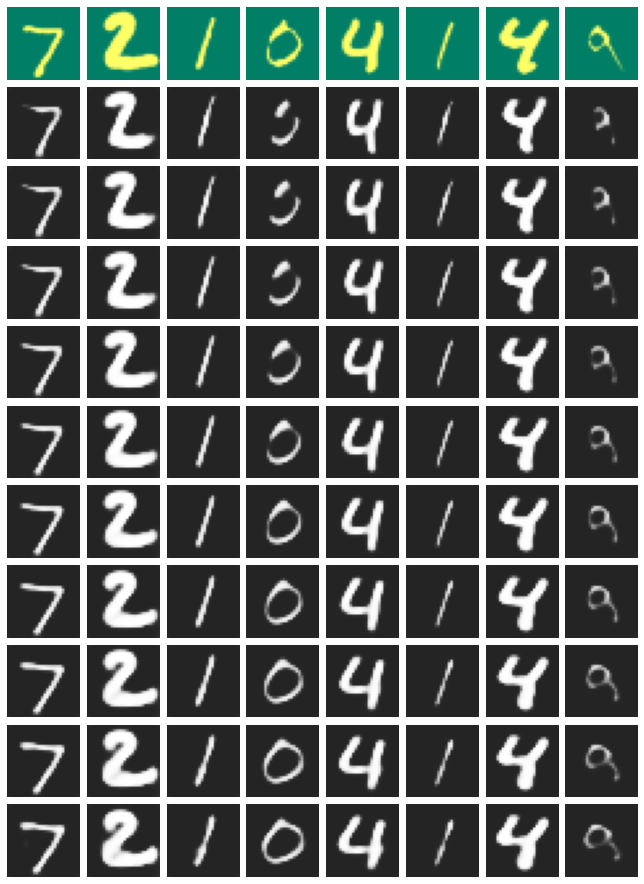

In [57]:
interpolate_and_display(model, 'width')